# Dataset Collection

This notebook is the first in a series created as part of the coding section for my bachelor thesis, which focuses on stock market analysis using machine learning techniques, specifically LSTMs, along with sentiment analysis and statistical methods.

In this notebook, I develop a web scraping bot to extract text and dates from various articles.

The code includes detailed comments to help readers easily understand and recreate the project on their own.

By the end of this notebook, you will obtain the following:

1. Files in .csv and .pkl formats containing articles about the specified company, including their publication dates and links.
2. Historical price data in .pkl format for the specified companies.
3. Stock volume data in .csv format which will be used for the notebook no. 5.

All the news have been extracted from https://business.financialpost.com/

In [ ]:
import requests
import urllib
import sys
import numpy  as np
import pandas as pd

from bs4 import BeautifulSoup

# 1. Extract web links according to a signature and the number of pages


In [ ]:
def get_internal_links(ur):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

    response = requests.get(ur, headers=headers, allow_redirects=True)

    # Check if the request was successful
    if response.status_code != 200:
        print(f"Failed to retrieve the page. Status code: {response.status_code}")
        return []

    soup = BeautifulSoup(response.content, 'html.parser')

    # Print the parsed content to debug - website may have changed
    # print(soup.prettify())

    links = []
    for div in soup.find_all("div", {"class": "article-card__details"}):
      for a in div.find_all('a', {"class": "article-card__link"}, href=True):
          links.append("https://financialpost.com" + a['href'])

    # print(links)
    return links

# Test the function
# get_internal_links("https://financialpost.com/search/?search_text=microsoft&date_range=-3650d&sort=score&from=80")

In [ ]:
def extract_link_of_news(k_word,n_of_page):
    link= "https://financialpost.com/search/?search_text="+ k_word + "&date_range=-3650d&sort=score&from=" + str((n_of_page-1)*10)
    news_df                  = pd.DataFrame()

    news_df["internal_urls"]  = get_internal_links(link)
    news_df["principal_url"]  = link
    news_df["n_of_page"]      = n_of_page
    return(news_df[["n_of_page","principal_url","internal_urls"]])

In [ ]:
# What kinds of stocks I was focusing on:
# Tech (growth) stocks: Microsoft, Nvidia, Apple, Google
# Dividend Stocks: Home Depot, Broadcom, Digital Realty Trust (REIT), J&J, Lockheed Martin
# Well known: Walmart, Pfizer, J&J, British American Tobacco, Coca cola, Pepsi, McDonald's, Starbucks

company_name = "Bitcoin" # Specify the company name to search for related articles on financialpost.com
n_of_pages = 988 # Maximum number of pages; this may vary depending on the website's structure at the time of execution
df = pd.concat([extract_link_of_news(company_name ,i) for i in range(1, n_of_pages + 1)], ignore_index = True)
df

,n_of_page,principal_url,internal_urls
0,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/pmn/new-york-judge-r...
1,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/globe-newswire/bitfa...
2,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/pmn/business-wire-ne...
3,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/pmn/business-pmn/bit...
4,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/technology/so-there-...
...,...,...,...
9875,988,https://financialpost.com/search/?search_text=...,https://financialpost.com/pmn/press-releases-p...
9876,988,https://financialpost.com/search/?search_text=...,https://financialpost.com/globe-newswire/purpo...
9877,988,https://financialpost.com/search/?search_text=...,https://financialpost.com/pmn/business-pmn/sto...
9878,988,https://financialpost.com/search/?search_text=...,https://financialpost.com/pmn/business-pmn/mar...


# 2. Extract the date and text from each link

In [ ]:
def extract_date_and_text(ur):
    url = ur
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
    }

    try:
        # Send request with User-Agent header to avoid potential blocking
        response = requests.get(url, headers=headers)

        # Log the status code to verify the request was successful
        # print(f"Fetching URL: {url}, Status Code: {response.status_code}")

        # Check if the request was successful
        if response.status_code != 200:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
            return "", "ERROR"

        # Parse HTML content
        soup = BeautifulSoup(response.content, 'html.parser')
        g = 0

    except Exception as e:
        # Log any exceptions during the request or parsing
        print(f"Error fetching URL: {url}, Exception: {e}")
        g = 1

    if g == 0:
        flag = True
        full_text_of_news = ""
        # Find all sections with the desired class and concatenate their paragraph text
        content_sections = soup.find_all("section", class_="article-content__content-group")
        if content_sections:
            text_of_news = []
            for section in content_sections:
                paragraphs = section.find_all("p")
                section_text = " ".join([p.text for p in paragraphs])  # Concatenate paragraphs in each section
                text_of_news.append(section_text)

            # Join all sections' text into one big string
            full_text_of_news = " ".join(text_of_news)
            # print(f"Found and concatenated article content for URL: {url}")  # Debugging output
            flag = False
        else:
            print(f"Article content not found for URL: {url}")  # Debugging output for missing content
            full_text_of_news = "NO TEXT"


        if flag:
            final_date = ""
            final_text = ""
        else:
            # Extract the article's publication date
            date_element = soup.find("span", class_="published-date__since")
            if date_element:
                final_date = date_element.text.replace("Published ", "").strip()
            else:
                final_date = "NO DATE"
                print(f"Date not found for URL: {url}")  # Debugging output for missing date

            # Join the text of the article paragraphs
            # get_text_vec = [i.text for i in text_of_news]
            # final_text = "".join(get_text_vec)
            final_text = full_text_of_news
            if final_text == "":
                print(f"No text found for URL: {url}")  # Debugging output for missing text
            else:
              # Define the unwanted starting phrases
              unwanted_start = "This article was created by StackCommerce."

              # Check if the text starts with the unwanted phrase and remove it if it does
              if final_text.startswith(unwanted_start):
                if len(final_text) > 137:
                  # print("Trimming the first 137 characters.")  # Debugging output
                  final_text = final_text[137:].strip()

    else:
        final_date = ""
        final_text = ""

    return final_date, final_text

In [ ]:
# Test the code to ensure it works (the cell after this one may take approximately 2-3 hours to execute, depending on the number of articles)
a = np.vectorize(extract_date_and_text)
test = df[0:10].copy()
test["internals_dates"],test["internals_text"] = a(test["internal_urls"][0:10])
test

,n_of_page,principal_url,internal_urls,internals_dates,internals_text
0,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/pmn/new-york-judge-r...,"Nov 15, 2024",NEW YORK (AP) — A cryptocurrency plant in cent...
1,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/globe-newswire/bitfa...,"Jan 03, 2022",This news release constitutes a “designated ne...
2,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/pmn/business-wire-ne...,"Nov 15, 2024",TORONTO — Kontrol Technologies Corp. ( NEO:KNR...
3,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/pmn/business-pmn/bit...,"Aug 12, 2024",(Bloomberg) — Bitcoin miner Marathon Digital H...
4,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/technology/so-there-...,"Feb 16, 2021","Bitcoin blew through another milestone, surgin..."
5,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/pmn/business-pmn/bit...,"Oct 19, 2024",(Bloomberg) — Six months after rewards for val...
6,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/technology/blockchai...,"Dec 11, 2017",Bitcoin has landed on Wall Street with a bang....
7,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/pmn/man-who-stole-an...,"Nov 14, 2024",WASHINGTON (AP) — A computer expert who stole ...
8,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/sponsored/business-s...,"Dec 16, 2021",Is Bitcoin’s carbon footprint keeping you from...
9,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/pmn/business-pmn/fiv...,"Nov 17, 2024",(Bloomberg) — Holdings in exchange-traded fund...


In [ ]:
# Extracting date and text from all articles and saving it to df. Make sure in the cell above that the code works!
a = np.vectorize(extract_date_and_text)
df["internals_dates"],df["internals_text"] = a(df["internal_urls"])

Failed to retrieve the page. Status code: 503
Failed to retrieve the page. Status code: 404
Failed to retrieve the page. Status code: 404
Failed to retrieve the page. Status code: 503


In [ ]:
df

,n_of_page,principal_url,internal_urls,internals_dates,internals_text
0,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/pmn/new-york-judge-r...,"Nov 15, 2024",NEW YORK (AP) — A cryptocurrency plant in cent...
1,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/globe-newswire/bitfa...,"Jan 03, 2022",This news release constitutes a “designated ne...
2,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/pmn/business-wire-ne...,"Nov 15, 2024",TORONTO — Kontrol Technologies Corp. ( NEO:KNR...
3,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/pmn/business-pmn/bit...,"Aug 12, 2024",(Bloomberg) — Bitcoin miner Marathon Digital H...
4,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/technology/so-there-...,"Feb 16, 2021","Bitcoin blew through another milestone, surgin..."
...,...,...,...,...,...
9875,988,https://financialpost.com/search/?search_text=...,https://financialpost.com/pmn/press-releases-p...,"Dec 06, 2022",Digital security in the palm of your hand PAR...
9876,988,https://financialpost.com/search/?search_text=...,https://financialpost.com/globe-newswire/purpo...,"Mar 15, 2024","TORONTO, March 15, 2024 (GLOBE NEWSWIRE) — Pur..."
9877,988,https://financialpost.com/search/?search_text=...,https://financialpost.com/pmn/business-pmn/sto...,"Apr 26, 2021",LONDON — Stocks gave up early gains on Monday ...
9878,988,https://financialpost.com/search/?search_text=...,https://financialpost.com/pmn/business-pmn/mar...,"Mar 31, 2021",LONDON — A new U.S. president with $1.9 trilli...


In [ ]:
# Define file paths for CSV and PKL files
csv_file_path = 'articles_dataset.csv'  # You can specify your own path
pkl_file_path = 'articles_dataset.pkl'  # You can specify your own path

# Save the DataFrame to CSV
df.to_csv(csv_file_path, index=False)

# Save the DataFrame to PKL
df.to_pickle(pkl_file_path)

# Historical Prices - dataset collection


In [ ]:
!pip install yfinance


In [ ]:
import yfinance as yf
import pandas as pd

# List of tickers: 3 growth tech stocks, 3 value stocks. Change it however you like
# Suggestions: WMT, LMT, STRB
tickers = ["MSFT", "NVDA", "AMZN", "LMT", "PG", "KO", "SBUX"] # "BTC-USD"

# Define the start and end dates for the 10-year period
start_date = '2014-11-15'
end_date = '2024-11-14'

# Download data
data = yf.download(tickers, start=start_date, end=end_date, progress=False)

# Extract only the 'Adj Close' prices
adj_close = data['Adj Close']

# Remove the time part from the index
adj_close.index = adj_close.index.date

# Display the shape and the first few records
adj_close.head()

adj_close.to_pickle("historical_prices.pkl")

# Plotting the historical prices

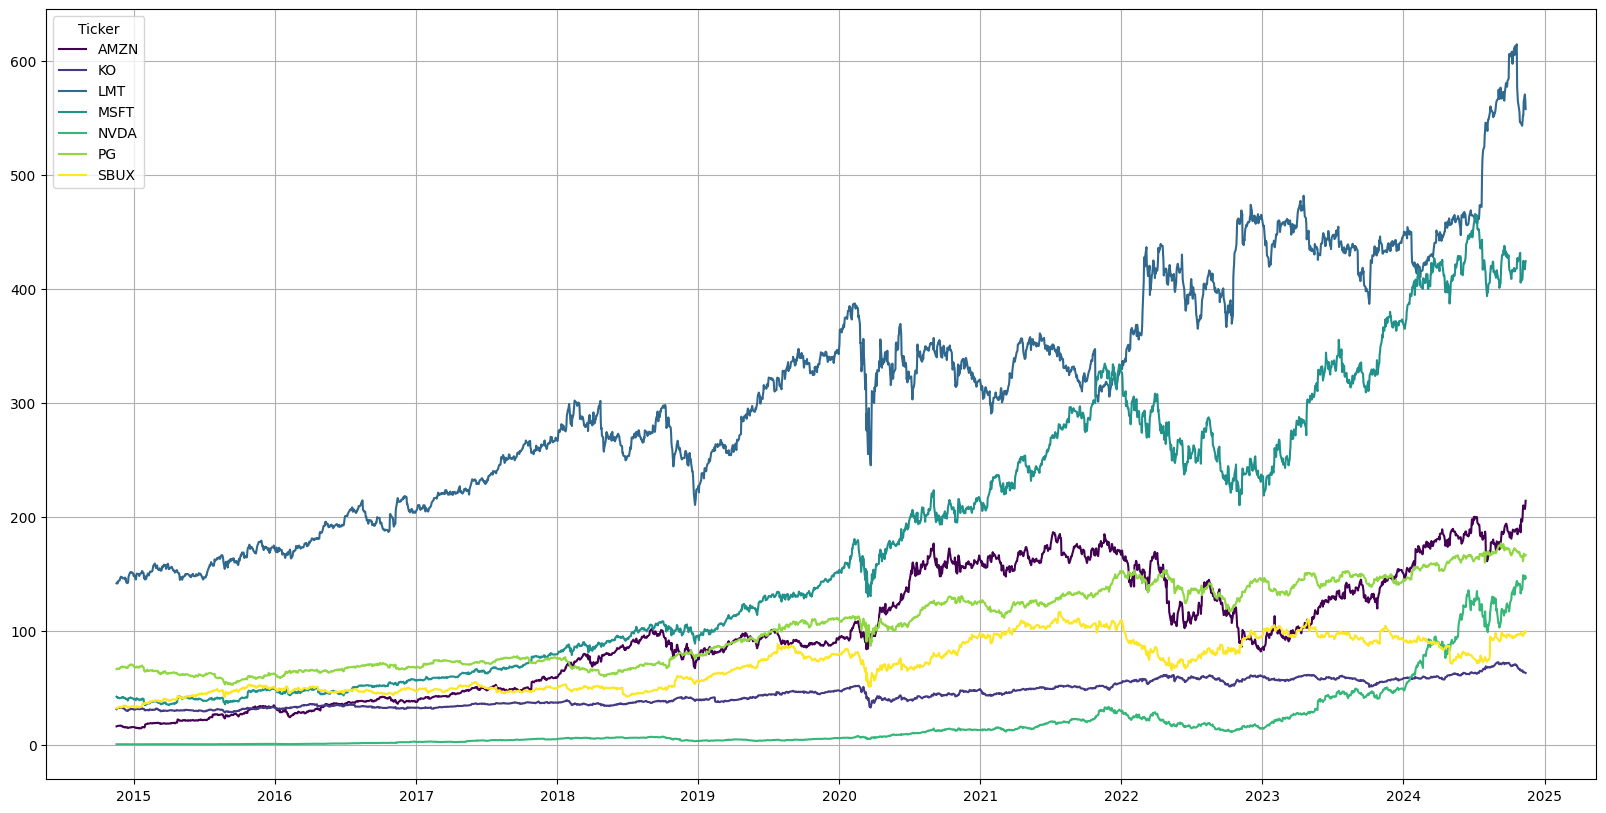

In [ ]:
import matplotlib.pyplot as plt

# plt.style.use('seaborn-dark')

adj_close.plot(cmap= "viridis",figsize=(20,10))
plt.grid()
plt.show()

# More data collection

In [ ]:
!pip install fredapi

In [ ]:
# fred api key 9ba76a38edbcc833792d14eae612e5b2
from fredapi import Fred

fred = Fred(api_key='9ba76a38edbcc833792d14eae612e5b2')

# Fetching interest rate data (e.g., Federal Funds Rate)
interest_rate = fred.get_series('FEDFUNDS')  # Federal Funds Rate
filtered_interest_rate = interest_rate.loc["2014-01-01":]
filtered_interest_rate

,0
2014-01-01,0.07
2014-02-01,0.07
2014-03-01,0.08
2014-04-01,0.09
2014-05-01,0.09
...,...
2024-06-01,5.33
2024-07-01,5.33
2024-08-01,5.33
2024-09-01,5.13


In [ ]:
# Resample the filtered data to daily frequency and fill missing values using forward fill
daily_interest_rate = filtered_interest_rate.resample("D").ffill()
daily_interest_rate


,0
2014-01-01,0.07
2014-01-02,0.07
2014-01-03,0.07
2014-01-04,0.07
2014-01-05,0.07
...,...
2024-09-27,5.13
2024-09-28,5.13
2024-09-29,5.13
2024-09-30,5.13


In [ ]:
daily_interest_rate.to_pickle("interest_rates_usa.pkl")

# Getting market cap

In [ ]:
import yfinance as yf
ticker_up = "AMZN"
data = yf.download(ticker_up, start="2014-11-01", end="2024-11-16")

# Approximate Market Cap
data['Market Cap'] = data['Adj Close'] * data['Volume']

data.reset_index(inplace=True)

# Display the data
print(data[['Date', 'Adj Close', 'Volume', 'Market Cap']])


[*********************100%***********************]  1 of 1 completed

Price                       Date   Adj Close    Volume    Market Cap
Ticker                                  AMZN      AMZN              
0      2014-11-03 00:00:00+00:00   15.286000  64850000  9.912971e+08
1      2014-11-04 00:00:00+00:00   15.140500  68548000  1.037851e+09
2      2014-11-05 00:00:00+00:00   14.826000  93490000  1.386083e+09
3      2014-11-06 00:00:00+00:00   14.832000  75162000  1.114803e+09
4      2014-11-07 00:00:00+00:00   14.993000  52948000  7.938494e+08
...                          ...         ...       ...           ...
2522   2024-11-11 00:00:00+00:00  206.839996  35456000  7.333719e+09
2523   2024-11-12 00:00:00+00:00  208.910004  38942900  8.135561e+09
2524   2024-11-13 00:00:00+00:00  214.100006  46212900  9.894182e+09
2525   2024-11-14 00:00:00+00:00  211.479996  42620300  9.013341e+09
2526   2024-11-15 00:00:00+00:00  202.610001  86591100  1.754422e+10

[2527 rows x 4 columns]


In [ ]:

# Retrieve company overview to get shares outstanding
overview_url = f'https://www.alphavantage.co/query?function=OVERVIEW&symbol={symbol}&apikey={api_key}'
overview_response = requests.get(overview_url)
overview_data = overview_response.json()
shares_outstanding = int(overview_data['SharesOutstanding'])

# Extract time series data
time_series = price_data['Time Series (Daily)']
dates = []
adjusted_closes = []

for date, daily_data in time_series.items():
    dates.append(date)
    adjusted_closes.append(float(daily_data['5. adjusted close']))

# Create DataFrame
df = pd.DataFrame({
    'Date': pd.to_datetime(dates),
    'Adjusted Close': adjusted_closes
})

# Filter dates between 2014-01-01 and 2024-11-16
start_date = '2014-01-01'
end_date = '2024-11-16'
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
df = df.loc[mask]

# Calculate market capitalization
df['Market Cap'] = df['Adjusted Close'] * shares_outstanding

# Reset index
df = df.sort_values('Date').reset_index(drop=True)

print(df)


NameError: name 'symbol' is not defined

# Getting Close and Volume data for Notebook no. 5

In [ ]:
import yfinance as yf
import pandas as pd

# Define the ticker symbol
ticker_up = "NVDA"  # Replace with your desired ticker

# Download data
data = yf.download(ticker_up, start="2014-11-01", end="2024-11-16", progress=False)

# Flatten the columns to 1D
close = data['Adj Close'].squeeze()
volume = data['Volume'].squeeze()

# Create a DataFrame with the desired columns
df = pd.DataFrame({
    'Date': data.index.date,  # Extract only the date part
    'Close': close,           # Close prices
    'Volume': volume          # Volume data
})

# Save the DataFrame to a CSV file
df.to_csv(ticker_up.lower() + "_close_volume.csv", index=False)

# Print the DataFrame to verify
print(df)

                                 Date       Close     Volume
Date                                                        
2014-11-03 00:00:00+00:00  2014-11-03    0.474926  308732000
2014-11-04 00:00:00+00:00  2014-11-04    0.481141  360196000
2014-11-05 00:00:00+00:00  2014-11-05    0.481141  335652000
2014-11-06 00:00:00+00:00  2014-11-06    0.483292  394088000
2014-11-07 00:00:00+00:00  2014-11-07    0.473014  450800000
...                               ...         ...        ...
2024-11-11 00:00:00+00:00  2024-11-11  145.259995  182325600
2024-11-12 00:00:00+00:00  2024-11-12  148.289993  198634700
2024-11-13 00:00:00+00:00  2024-11-13  146.270004  191903300
2024-11-14 00:00:00+00:00  2024-11-14  146.759995  194463300
2024-11-15 00:00:00+00:00  2024-11-15  141.979996  250132900

[2527 rows x 3 columns]
